In [1]:
using Oceananigans
using Oceananigans.OutputWriters, Oceananigans.Fields
using Oceananigans.Utils:day, hour, minute, second
using Plots, JLD2, Printf, Oceananigans.Grids

In [2]:
gr()

Plots.GRBackend()

In [3]:
function fileremover(files)
    dir=readdir()
    for filename in files
        if (filename in dir)
            rm(filename)
        end
    end
end

fileremover (generic function with 1 method)

In [4]:
grid1 = RegularCartesianGrid(size=(60,1,60), x=(-0.5,0.5),y=(0,1), z=(-0.5,0.5), topology = (Periodic, Bounded, Bounded))

@inline Uvel(x,y,t)=0.25+0.125sin((2π*t)/40)+t/30
@inline botUvel(x,y,t)=-0.25+0.125cos((2π*t)/40)-t/30

u_bcs = UVelocityBoundaryConditions(grid1, bottom = BoundaryCondition(Value,botUvel), top=BoundaryCondition(Value,Uvel))

t_bcs = TracerBoundaryConditions(grid1, bottom = BoundaryCondition(Value,2.), top=BoundaryCondition(Value,28.))

model1 = IncompressibleModel(grid=grid1, boundary_conditions=(T=t_bcs,u=u_bcs,),tracers=(:T,:S),
    closure=IsotropicDiffusivity(ν=8.9e-4, κ=1.43e-7),timestepper = :RungeKutta3)

println(model1)
println(model1.velocities.u)
println(model1.tracers.T)

@inline randvel(x,y,z)=randn()
@inline randtemp(x,y,z)=18+5randn()
@inline randsal(x,y,z)=-15tanh(10z)+15
@inline thermoc(x,y,z)=16tanh(10z)+15
set!(model1,T=thermoc,S=randsal,u=randvel,v=randvel,)

wizard=TimeStepWizard(cfl=0.1, Δt=0.0001, max_Δt=10.)

simulation = Simulation(model1, Δt=wizard, stop_time=2minute, iteration_interval=4)

function init_save_some_metadata!(file, model)
    file["author"] = "oofs"
    return nothing
end

IncompressibleModel{CPU, Float64}(time = 0 seconds, iteration = 0) 
├── grid: RegularCartesianGrid{Float64, Periodic, Bounded, Bounded}(Nx=60, Ny=1, Nz=60)
├── tracers: (:T, :S)
├── closure: IsotropicDiffusivity{Float64,NamedTuple{(:T, :S),Tuple{Float64,Float64}}}
├── buoyancy: SeawaterBuoyancy{Float64,LinearEquationOfState{Float64},Nothing,Nothing}
└── coriolis: Nothing
Field located at (Face, Cell, Cell)
├── data: OffsetArrays.OffsetArray{Float64,3,Array{Float64,3}}, size: (62, 3, 62)
├── grid: RegularCartesianGrid{Float64, Periodic, Bounded, Bounded}(Nx=60, Ny=1, Nz=60)
└── boundary conditions: x=(west=Periodic, east=Periodic), y=(south=ZeroFlux, north=ZeroFlux), z=(bottom=Value, top=Value)
Field located at (Cell, Cell, Cell)
├── data: OffsetArrays.OffsetArray{Float64,3,Array{Float64,3}}, size: (62, 3, 62)
├── grid: RegularCartesianGrid{Float64, Periodic, Bounded, Bounded}(Nx=60, Ny=1, Nz=60)
└── boundary conditions: x=(west=Periodic, east=Periodic), y=(south=ZeroFlux, north=ZeroFlu

init_save_some_metadata! (generic function with 1 method)

In [7]:
fileremover(["UnstableVelocityDataLidCavity.jld2","UnstableTempDataLidCavity.jld2"])

simulation.output_writers[:velocities] = JLD2OutputWriter(model1, model1.velocities,
                                                          prefix = "UnstableVelocityDataLidCavity",
                                                          schedule = TimeInterval(0.5second),
                                                          init = init_save_some_metadata!)

simulation.output_writers[:tracers] = JLD2OutputWriter(model1, model1.tracers,
                                                          prefix = "UnstableTempDataLidCavity",
                                                          schedule = TimeInterval(0.5second),
                                                          init = init_save_some_metadata!)



run!(simulation)

┌ Warning: Could not initialize ./UnstableVelocityDataLidCavity.jld2: data may already be initialized.
└ @ Oceananigans.OutputWriters /Users/jerobinett/.julia/packages/Oceananigans/RxUYW/src/OutputWriters/jld2_output_writer.jl:180
┌ Warning: Could not initialize ./UnstableTempDataLidCavity.jld2: data may already be initialized.
└ @ Oceananigans.OutputWriters /Users/jerobinett/.julia/packages/Oceananigans/RxUYW/src/OutputWriters/jld2_output_writer.jl:180


JLD2OutputWriter scheduled on TimeInterval(500 ms):
├── filepath: ./UnstableTempDataLidCavity.jld2
├── 2 outputs: (:T, :S)
├── field slicer: FieldSlicer(:, :, :, with_halos=false)
├── array type: Array{Float32}
├── including: [:grid, :coriolis, :buoyancy, :closure]
└── max filesize: Inf YiB

┌ Info: Saved animation to 
│   fn = /Users/jerobinett/Desktop/JuliaPractice/Stable Lid-Driven Cavity U-Velocity.gif
└ @ Plots /Users/jerobinett/.julia/packages/Plots/5ItHH/src/animation.jl:104


Plots.AnimatedGif("/Users/jerobinett/Desktop/JuliaPractice/Stable Lid-Driven Cavity U-Velocity.gif")
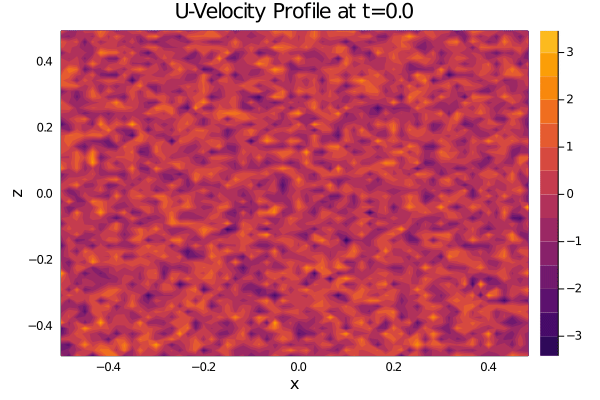

In [8]:
x, y, z = nodes(model1.velocities.u)
let

    file = jldopen(simulation.output_writers[:velocities].filepath)
    iterations = parse.(Int, keys(file["timeseries/t"]))
    anim = @animate for (i, iter) in enumerate(iterations)

        uvel = transpose(file["timeseries/u/$iter"][:,1,:])
        timeofthing=file["timeseries/t/$iter"]

        y=contourf(x, z, uvel, title = "U-Velocity Profile at t=$timeofthing",linewidth=0,xlabel = "x",ylabel = "z",levels=-5:0.5:5)
    end
    gif(anim, "Stable Lid-Driven Cavity U-Velocity.gif", fps = 24)
end

┌ Info: Saved animation to 
│   fn = /Users/jerobinett/Desktop/JuliaPractice/Stable Lid-Driven Cavity Temperature.gif
└ @ Plots /Users/jerobinett/.julia/packages/Plots/5ItHH/src/animation.jl:104


Plots.AnimatedGif("/Users/jerobinett/Desktop/JuliaPractice/Stable Lid-Driven Cavity Temperature.gif")
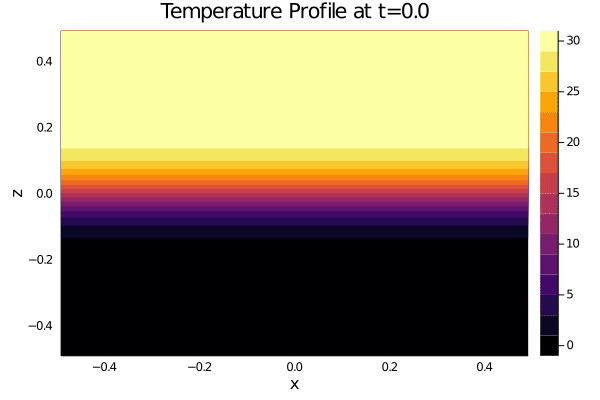

In [9]:
let
    x,y,z=nodes(model1.tracers.T)
    file = jldopen(simulation.output_writers[:tracers].filepath)
    iterations = parse.(Int, keys(file["timeseries/t"]))
    anim = @animate for (i, iter) in enumerate(iterations)

        T = transpose(file["timeseries/T/$iter"][:,1,:])
        timeofthing=file["timeseries/t/$iter"]

        contourf(x, z, T, title = "Temperature Profile at t=$timeofthing",linewidth=0,xlabel = "x",ylabel = "z")
    end
    gif(anim, "Stable Lid-Driven Cavity Temperature.gif", fps = 24)
end